In [1]:
using Bolt, Plots,ThreadPools

FRW Background setup

In [ ]:
# Assign cosmological parameters
𝕡 = CosmoParams(Ω_c = 0.3) # set kwargs like so to change the default values

# Compute expansion history quantities
bg = Background(𝕡)

# Compute ionization history (via RECFAST)
𝕣 = Bolt.RECFAST(bg=bg, Yp=𝕡.Y_p, OmegaB=𝕡.Ω_b)
ih = IonizationHistory(𝕣, 𝕡, bg)

### $P_{L}(k)$

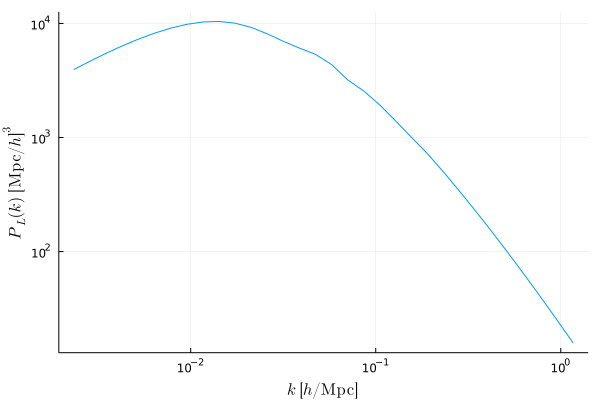

In [3]:
# Matter power spectrum
kmin,kmax,nk = 10bg.H₀,5000bg.H₀,32
ks = log10_k(kmin,kmax,nk) # k grid
pL = [plin(k,𝕡,bg,ih) for k in ks]
p1 = plot(ks, vcat(pL...), xscale=:log10, yscale=:log10,label=false,
          xlabel=raw"$k \ [h/\mathrm{Mpc}]$", ylabel=raw"$P_L(k) \ [\mathrm{Mpc}/h]^3$")

### $C^{TT}(\ell)$

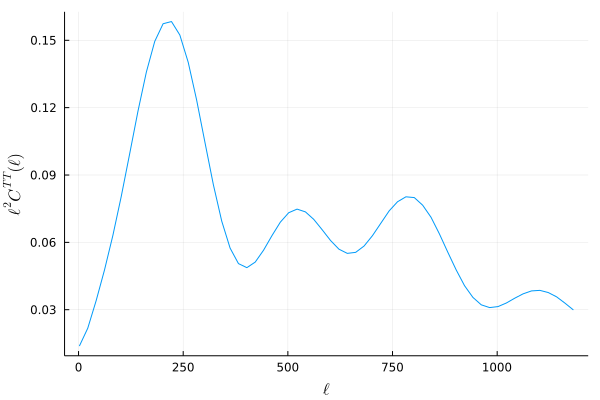

In [4]:
# CMB Cᵀᵀ(ℓ)
ℓmin,ℓmax,nℓ = 2,20,1200
ℓs = ℓmin:ℓmax:nℓ
kmin,kmax,nk = 0.1bg.H₀, 1000bg.H₀, 100
ks = quadratic_k(kmin,kmax,nk)
sf = source_grid(𝕡, bg, ih, ks, BasicNewtonian()) # set up LOS source function interpolator
Cᵀᵀ = cltt(ℓs, 𝕡, bg, ih, sf)
p2 = plot(ℓs, @.(ℓs^2*Cᵀᵀ),label=false,xlabel=raw"$\ell$", ylabel=raw"$\ell^2 C^{TT}(\ell)$")